In [1]:
import sys
print(sys.executable)

c:\Users\slab\anaconda3\python.exe


In [2]:
import _ssl

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import yaml
from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
import qutip as qt
import time 
import matplotlib.pyplot as plt

from TomoAnalysis import TomoAnalysis
from TomoILC import TomoILC 

%matplotlib widget

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
plt.rcParams['animation.html'] = 'jshtml'

ModuleNotFoundError: No module named 'numpy'

# Parameters

In [2]:
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [3]:
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
pulse_IQ = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_IQ.update({key:npzfile[key]})

In [5]:
pulse_IQ.keys()

dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])

In [4]:
pulse_filename

psi_str = pulse_filename.split('_')[-1] 
q0 = psi_str[0]
q1 = psi_str[1]

# define the psi_ideal 

if q0 =='0':
    psi0 = qt.basis(2,0)
elif q0 == '1':
    psi0 = qt.basis(2,1)
elif q0 == '+':
    psi0 = (qt.basis(2,0) + qt.basis(2,1)).unit()

if q1 =='0':
    psi1 = qt.basis(2,0)
elif q1 == '1':
    psi1 = qt.basis(2,1)
elif q1 == '+':
    psi1 = (qt.basis(2,0) + qt.basis(2,1)).unit()
    
psi_ideal = qt.tensor(psi0, psi1)
rho_ideal = psi_ideal * psi_ideal.dag()

In [5]:
tomo_ILC = TomoILC(
    IQ_pulse_seed=pulse_IQ, 
    gains_filename=pulse_filename, 
    nb_qubits=2, 
    n_shot_calib=4000, 
    n_shot_tomo=4000, 
    qubit_drive=[0, 1],
    debug=False
)

# 2D map vs amplitude

In [145]:
amp_q0_vec = np.linspace(0.99, 1.01, 5)
amp_q1_vec = np.linspace(0.99, 1.01, 5)
# create a list of pulse dict rescaled by the amplitude
pulse_IQ_rescaled = dict()

for amp_q0 in amp_q0_vec:
    for amp_q1 in amp_q1_vec:
        pulse_IQ_rescaled.update({
            f'{amp_q0}_{amp_q1}': {
                'times': pulse_IQ['times'],
                'I_0': pulse_IQ['I_0']*amp_q0,
                'Q_0': pulse_IQ['Q_0']*amp_q0,
                'I_1': pulse_IQ['I_1']*amp_q1,
                'Q_1': pulse_IQ['Q_1']*amp_q1,
            }
        })

In [146]:
# loop over the rescaled pulses

rho_dict = {}
fidelity_dict = {}
for key, pulse in pulse_IQ_rescaled.items():
    print(f'Running ILC for pulse {key}')
    rho = tomo_ILC.get_tomo_results(pulse)
    rho = qt.Qobj(rho)
    rho.dims = rho_ideal.dims
    fidelity = qt.fidelity(rho, rho_ideal)
    
    rho_dict[key] = rho
    fidelity_dict[key] = fidelity

Running ILC for pulse 0.99_0.99
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.99_0.995
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.99_1.0
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.99_1.005
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.99_1.01
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.995_0.99
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.995_0.995
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.995_1.0
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.995_1.005
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 0.995_1.01
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.0_0.99
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.0_0.995
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.0_1.0
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.0_1.005
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.0_1.01
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.005_0.99
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.005_0.995
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.005_1.0
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.005_1.005
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.005_1.01
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.01_0.99
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.01_0.995
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.01_1.0
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.01_1.005
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5
Running ILC for pulse 1.01_1.01
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[524.6306674284309, 501.26868957481906, 0, 0],
angles=[-26.52109002701924, -168.1412498261473, 0, 0],
ge_avgs=[[ 276.57701251  130.99532862  724.50750336  322.1277617 ]
 [-308.13530859  190.17999699 -637.22136605  251.96210938]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[3190, 433, 316, 61], [491, 3118, 104, 287], [372, 66, 3019, 543], [144, 348, 504, 3004]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00045_OptimalCtrlTomo2Q_01.h5


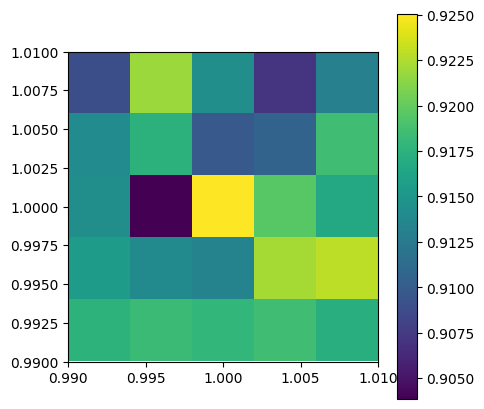

In [151]:
# plot the fidelity as a function of the pulse amplitude

import matplotlib.pyplot as plt

fidelity_mat = np.zeros((len(amp_q0_vec), len(amp_q1_vec)))
for i, amp_q0 in enumerate(amp_q0_vec):
    for j, amp_q1 in enumerate(amp_q1_vec):
        key = f'{amp_q0}_{amp_q1}'
        fidelity_mat[i,j] = fidelity_dict[key]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(fidelity_mat, extent=[amp_q0_vec[0], amp_q0_vec[-1], amp_q1_vec[0], amp_q1_vec[-1]])

# add the colorbar ranging from 0.9 to 1 

plt.colorbar(im, ax=ax)

In [44]:
tomo_analysis = TomoAnalysis(nb_qubits=2,
                             tomo_qubits=[0, 1],
                             rfsoc_config=tomo_ILC.rfsoc_config)                        

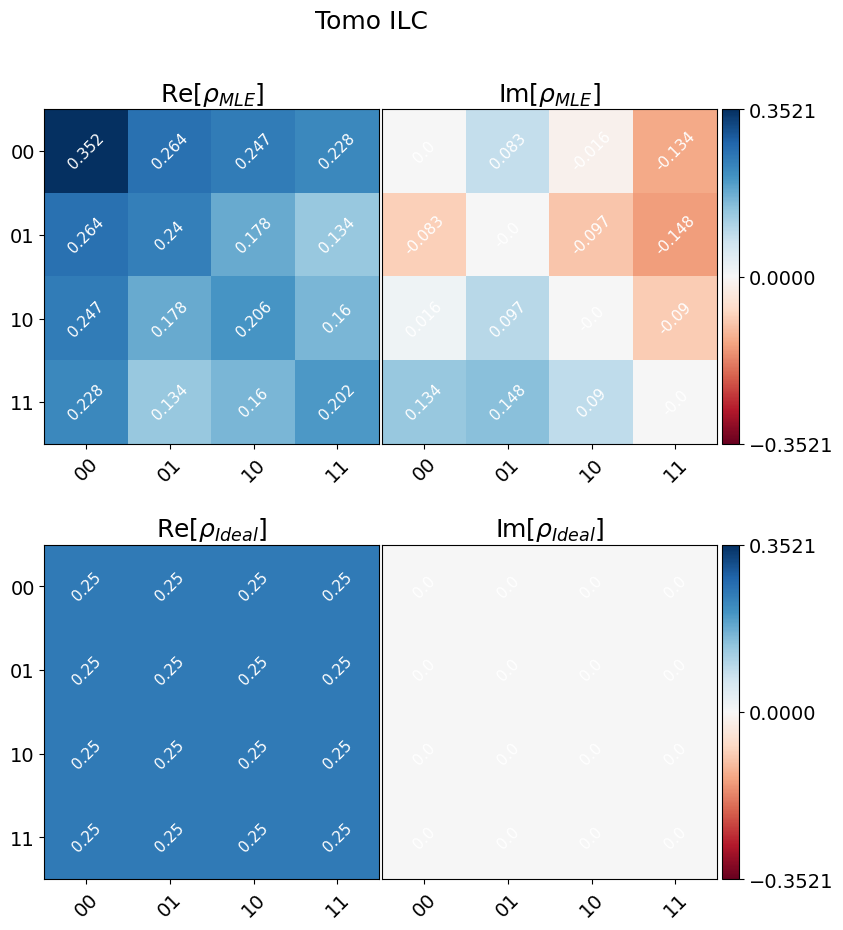

In [153]:
# plot the best fidelity

max_fidelity = np.max(fidelity_mat)
max_idx = np.where(fidelity_mat == max_fidelity)
best_amp_q0 = amp_q0_vec[max_idx[0][0]]
best_amp_q1 = amp_q1_vec[max_idx[1][0]]
best_key = f'{best_amp_q0}_{best_amp_q1}'
rho = rho_dict[best_key]


tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')

# Measure the fidelity versus time

In [27]:
max_time = 60*20 # seconds

time_vec = []
fidelity_vec = []

Text(0, 0.5, 'Fidelity')

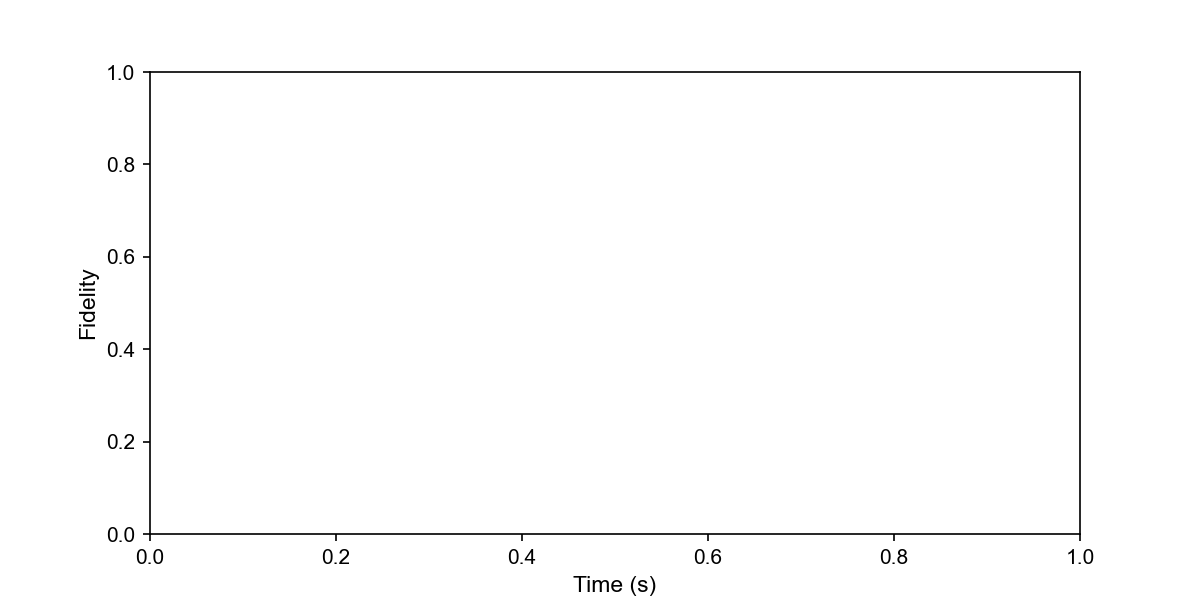

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fidelity')

In [29]:
start_time = time.time()

tomo_ILC = TomoILC(
    IQ_pulse_seed=pulse_IQ, 
    gains_filename=pulse_filename, 
    nb_qubits=2, 
    n_shot_calib=20000, 
    n_shot_tomo=20000, 
    qubit_drive=[0, 1],
    debug=False
)
while time.time() - start_time < max_time:
    rho = tomo_ILC.get_tomo_results(pulse_IQ)
    rho = qt.Qobj(rho)
    rho.dims = rho_ideal.dims
    fidelity = qt.fidelity(rho, rho_ideal)
    
    time_vec.append(time.time() - start_time)
    fidelity_vec.append(fidelity)    
    
    ax.clear()
    ax.plot(time_vec, fidelity_vec, 'o-')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fidelity')
    fig.canvas.draw()

gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.11 	 angle (deg): 117.9424638051488 	 threshold ge: 559.234302613226
Qubit (1)
ge fidelity (%): 73.37683442086053 	 angle (deg): -171.2853938192537 	 threshold ge: 512.256472308235
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702196906, -263.2964153783564, -409.6310613100081, -678.5089420870627], [-308.9955751302083, 223.08860971679687, -638.8653007324219, 267.49179191080725], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5
gains:  [6500 9750]
gainpts Q0 [6500]
gainpts Q1 [9750]
Re-using provided angles, thresholds, ge_avgs, counts_calib
thresholds=[559.234302613226, 512.256472308235, 0, 0],
angles=[117.9424638051488, -171.2853938192537, 0, 0],
ge_avgs=[[-163.67168702 -263.29641538 -409.63106131 -678.50894209]
 [-308.99557513  223.08860972 -638.86530073  267.49179191]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]],
counts_calib=[[16416, 1909, 1435, 240], [2628, 15559, 552, 1261], [2150, 363, 15120, 2367], [856, 2699, 2627, 13818]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00047_OptimalCtrlTomo2Q_01.h5


In [47]:
shots = tomo_ILC.tomoExpt.data['counts_tomo_gains'][0][0]
calib_shots = tomo_ILC.tomoExpt.data['counts_calib']

rho = tomo_analysis.get_rho_from_counts(shots, calib_shots)

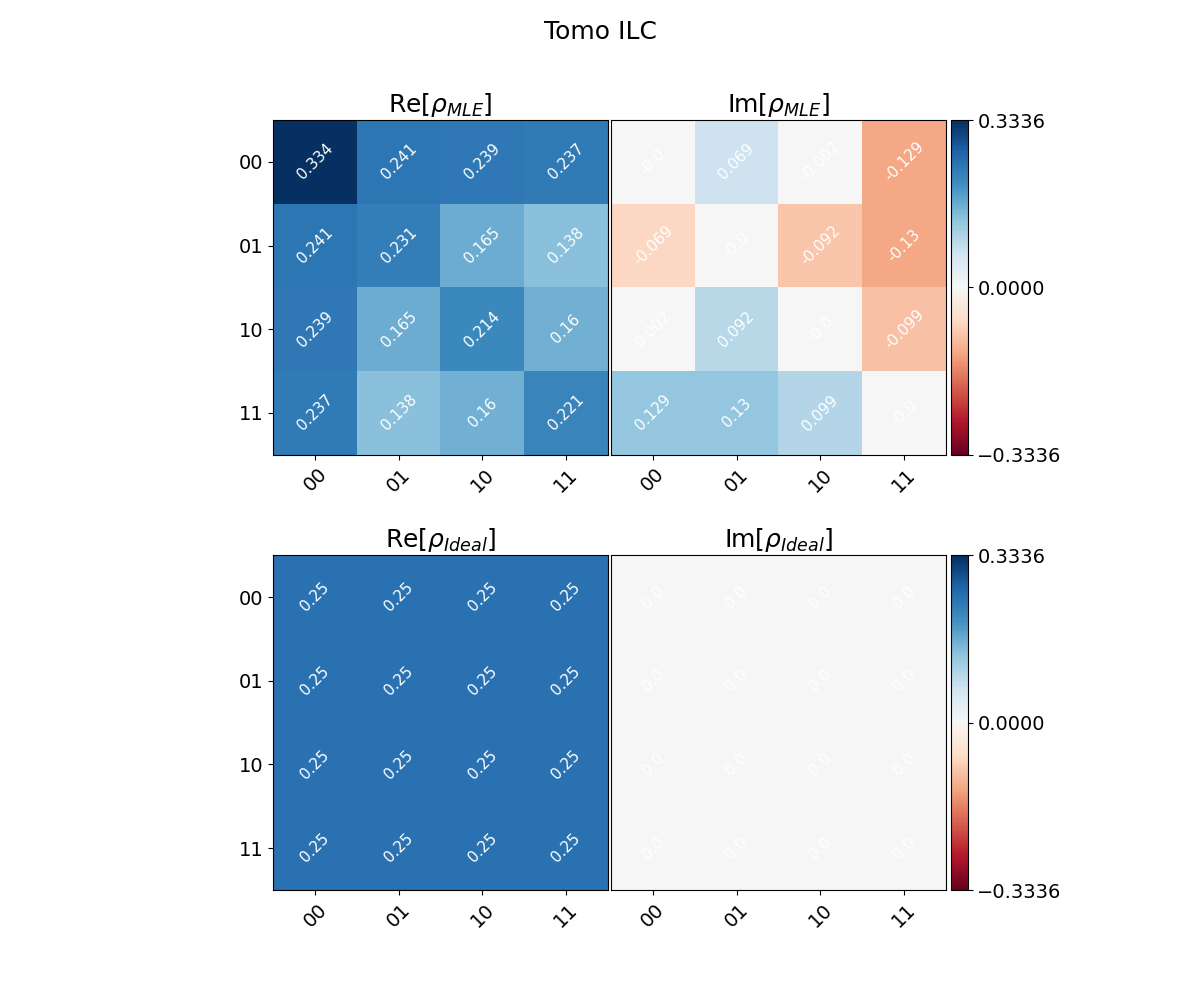

In [50]:
# plot the best fidelity

tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')

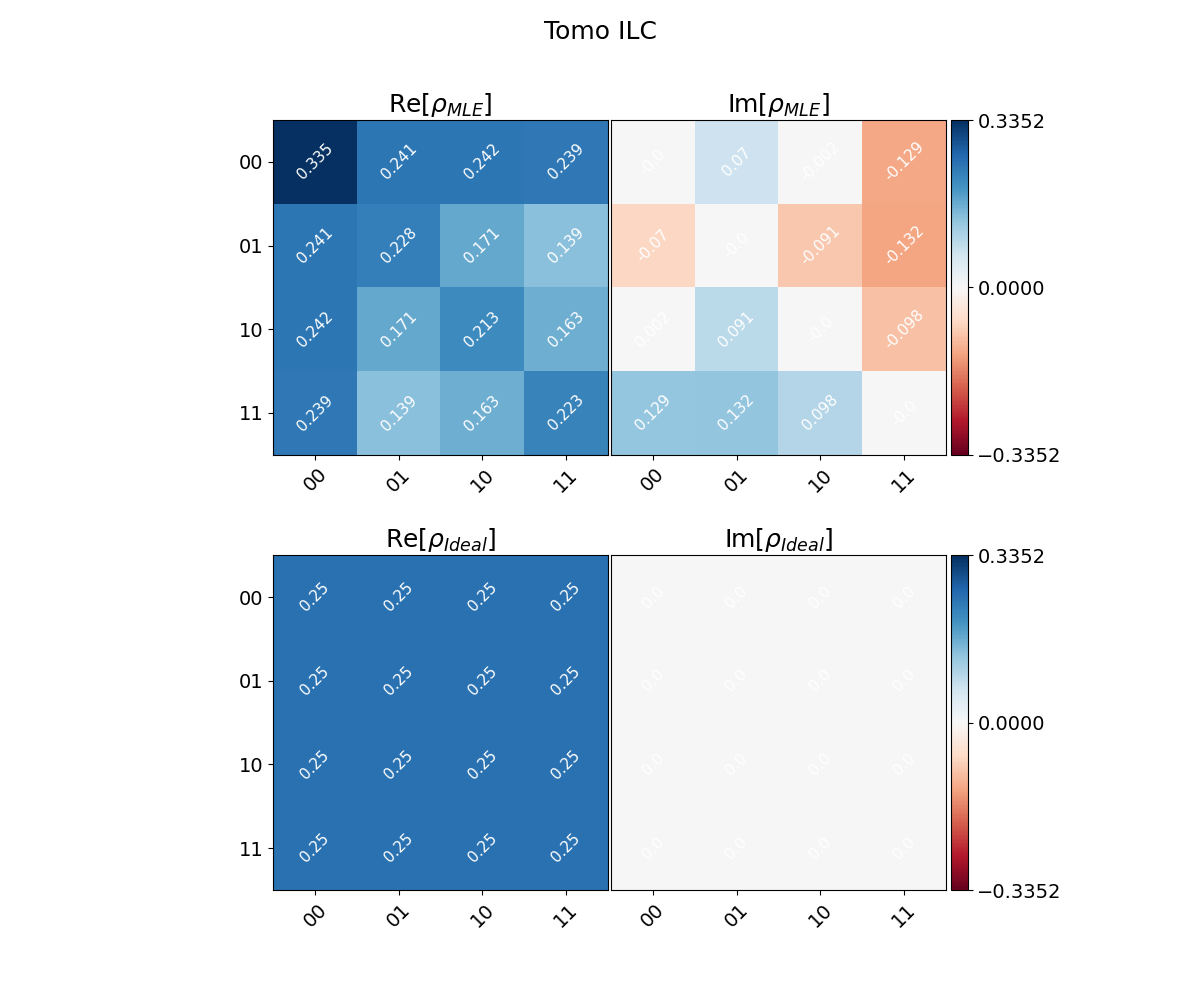

In [52]:
rho = tomo_analysis.get_rho_from_counts(shots, calib_shots)
tomo_analysis.show_plot_rho_2d(rho,rho_id=rho_ideal.full(), title='Tomo ILC')